In [29]:
import pandas as pd
import tushare as ts
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.colors import DEFAULT_PLOTLY_COLORS
from utils import get_data
import datetime
pro = ts.pro_api()
today = datetime.datetime.today()
cur_year = str(today.year)

# 设置参数

In [15]:
comp_dicts = {'603589':'口子窖',
            '000596':'古井贡酒',
            '603189':'迎驾贡酒',
            '600199':'金种子酒'}
# 000672 上峰水泥
# 600585 海螺水泥
# 300552 万集科技
# 002869 金溢科技
# 601318 中国平安


target_code = '002714'
# target_code = '002304' # y洋河

In [16]:
is_ann_report = True
start_year = '2010'

# 支持季度

In [17]:
for k,v in list(comp_dicts.items()):
    if "." in k: continue
    surfix = '.SH' if k.startswith('6') else '.SZ'
    comp_dicts.pop(k)
    comp_dicts[k+surfix] = v
    
ts_codes = ','.join(comp_dicts.keys())    ### 这个暂时没用
target_code = target_code + ('.SH' if target_code.startswith('6') else '.SZ')

In [18]:
if is_ann_report:
    report_type = 1
    date_filter = lambda x:(x.endswith('1231')) and x>start_year
else:
    report_type = 2
    date_filter = lambda x:x>start_year


In [233]:
data_df = get_data(target_code, date_filter)

# ROE 分析

## ROE & ROA

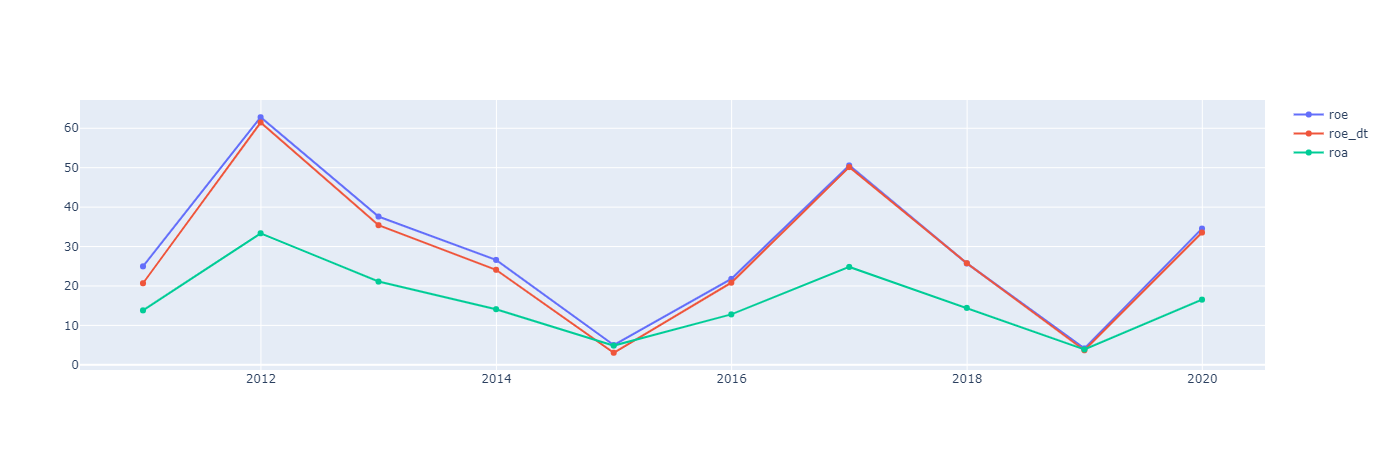

In [234]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data_df.index, y=data_df.roe,name='roe'))
fig.add_trace(go.Scatter(x=data_df.index, y=data_df.roe_dt,name='roe_dt'))
fig.add_trace(go.Scatter(x=data_df.index, y=data_df.roa,name='roa'))
# fig.add_trace(go.Scatter(x=data_df.index, y=data_df.roe_dt,name='roe_dt'))
fig.show()

## 杜邦分析

In [235]:
from plotly.subplots import make_subplots

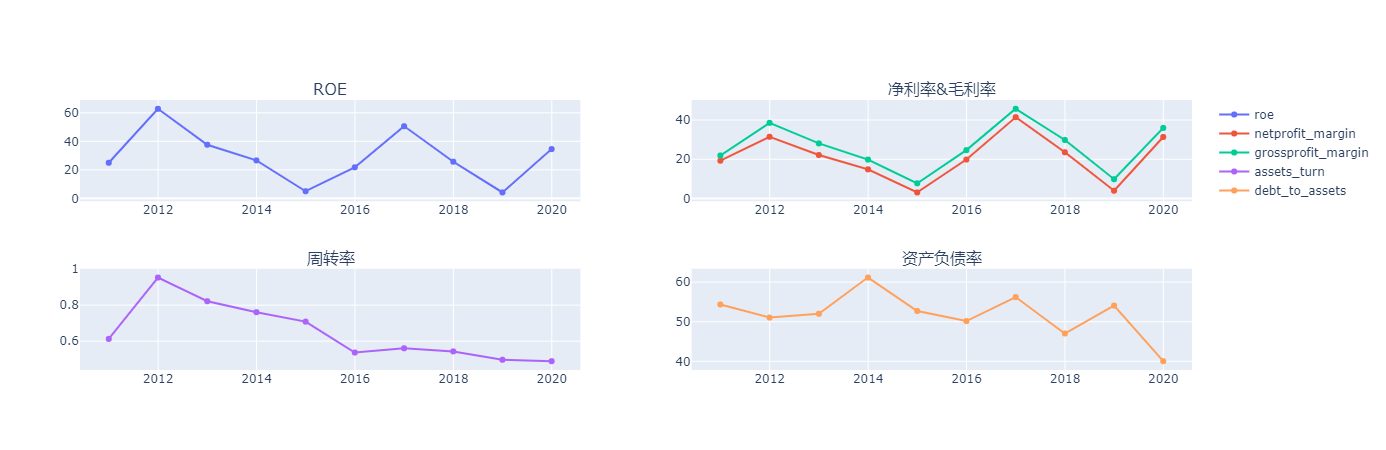

In [236]:
fig = make_subplots(2,2,
                   subplot_titles=['ROE','净利率&毛利率','周转率','资产负债率'])
fig.append_trace(go.Scatter(x=data_df.index, y=data_df.roe,name='roe'),1,1)

fig.append_trace(go.Scatter(x=data_df.index, y=data_df.netprofit_margin,name='netprofit_margin'),1,2)
fig.append_trace(go.Scatter(x=data_df.index, y=data_df.grossprofit_margin,name='grossprofit_margin', yaxis='y2'),1,2)

fig.append_trace(go.Scatter(x=data_df.index, y=data_df.assets_turn,name='assets_turn'),2,1)

fig.append_trace(go.Scatter(x=data_df.index, y=data_df.debt_to_assets,name='debt_to_assets'),2,2)
fig.show()

# 风险分析-结构

## 应收

In [237]:
cols_rec = {"notes_receiv":"应收票据",
"accounts_receiv":"应收账款",
"oth_receiv":"其他应收款",
"lt_amor_exp":"长期待摊费用"}

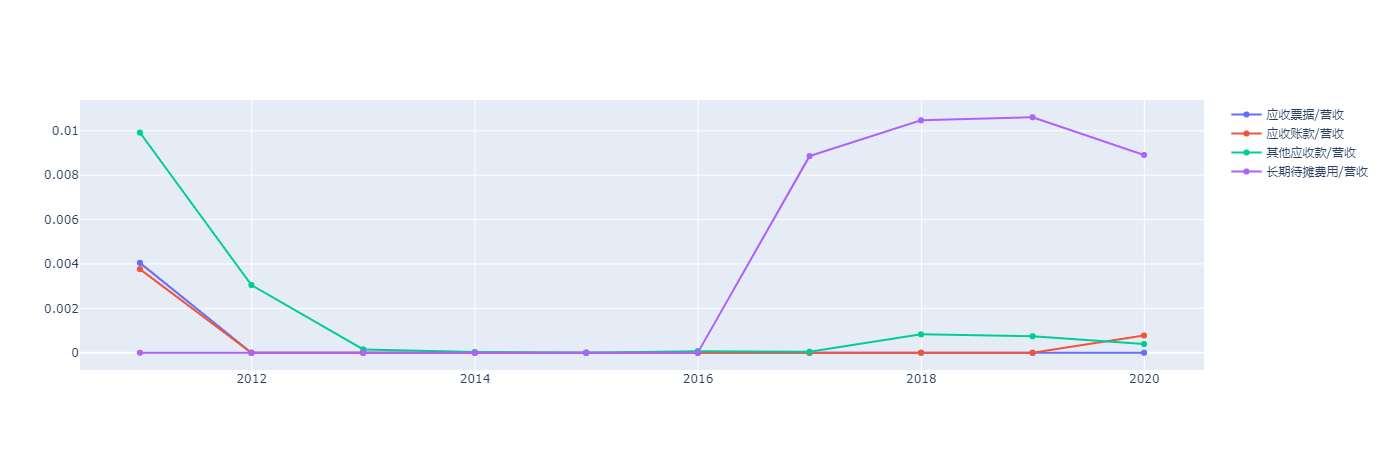

In [238]:
fig = go.Figure()
for col in cols_rec:
    fig.add_trace(go.Scatter(x=data_df.index, y=data_df[col]/data_df.total_revenue, name=cols_rec[col]+"/营收"))
fig.show()

## 应付

In [239]:
cols_pay = {"notes_payable":"应付票据",
"acct_payable":"应付账款",
"oth_payable":"其他应付款",
"st_borr":"短期借款",}

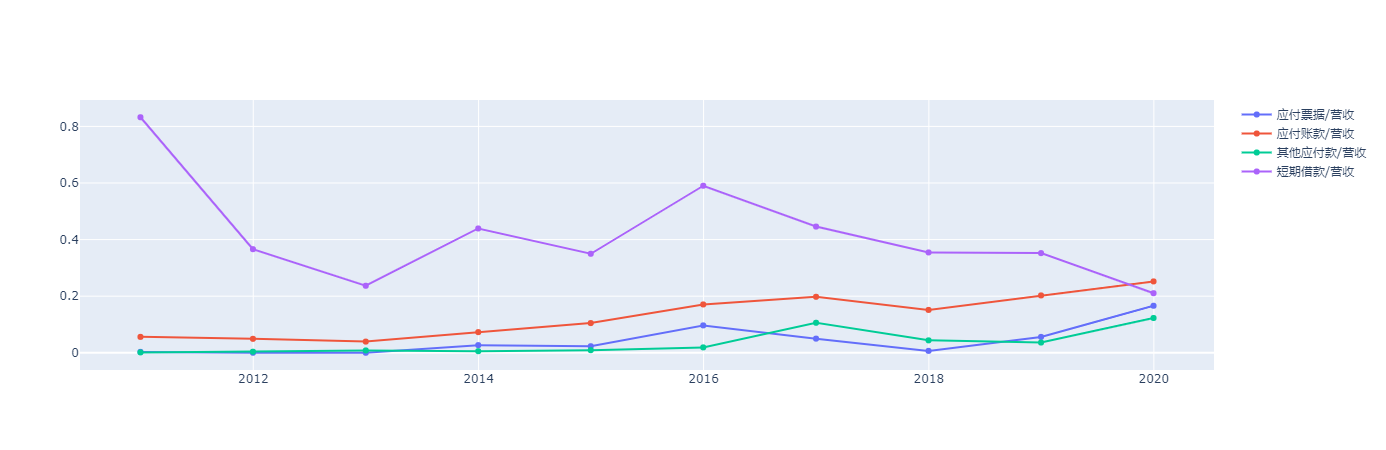

In [240]:
fig = go.Figure()
for col in cols_pay:
    fig.add_trace(go.Scatter(x=data_df.index, y=data_df[col]/data_df.total_revenue, name=cols_pay[col]+"/营收"))
fig.show()

## 核心利润&营业利润

In [241]:
data_df['oper_profit'] = data_df['revenue'] - (
        data_df[["oper_cost", "int_exp", "comm_exp", "biz_tax_surchg", "sell_exp", "admin_exp", "prem_refund",
                 "compens_payout", "reser_insur_liab", "div_payt", "reins_exp", "compens_payout_refu",
                 "insur_reser_refu", "reins_cost_refund", "other_bus_cost"]].sum(axis=1) + 
    data_df['fin_exp'].apply(lambda x: x if x > 0 else 0) + 
    data_df['assets_impair_loss'].apply(lambda x: x if x > 0 else 0)
)
## 暂时可能不适用于金融类公司
data_df['oper_profit_ratio'] = data_df['oper_profit']/data_df['revenue']*100

In [242]:
## 公允、投资、减值
data_df['gtj_to_oper'] = data_df[['fv_value_chg_gain','invest_income','assets_impair_loss']].sum(axis=1) / data_df['operate_profit'] *100

In [243]:
## 净利/营业利润
data_df['n_to_oper'] = data_df['n_income'] / data_df['operate_profit'] *100

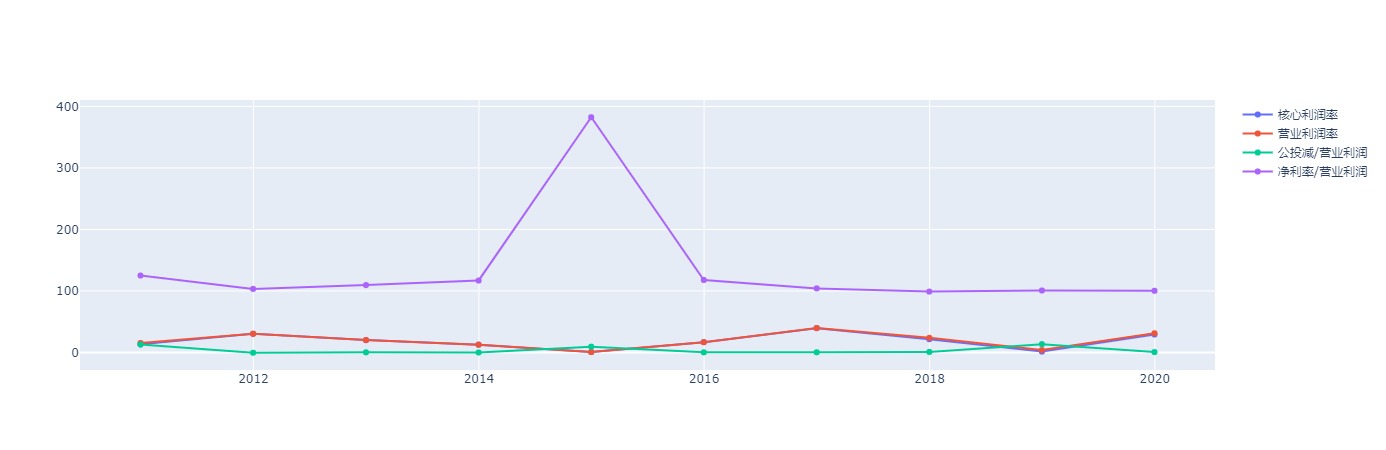

In [244]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data_df.index, y=data_df['oper_profit_ratio'],name='核心利润率'))
fig.add_trace(go.Scatter(x=data_df.index, y=data_df['op_of_gr'],name='营业利润率'))
fig.add_trace(go.Scatter(x=data_df.index, y=data_df['gtj_to_oper'],name='公投减/营业利润'))
fig.add_trace(go.Scatter(x=data_df.index, y=data_df['n_to_oper'],name='净利率/营业利润'))


fig.show()



# 安全性

## 有息负债率

In [245]:
cols_yx_debts = {
    "lt_borr":"长期借款",
"st_borr":"短期借款",
"cb_borr":"向中央银行借款",
"trading_fl":"交易性金融负债",
"sold_for_repur_fa":"卖出回购金融资产款",
"st_bonds_payable":"应付短期债券",
"non_cur_liab_due_1y":"一年内到期的非流动负债",
"oth_cur_liab":"其他流动负债",
"bond_payable":"应付债券",
"oth_ncl":"其他非流动负债",
}
data_df['debts_yx'] = data_df[cols_yx_debts.keys()].sum(axis=1)

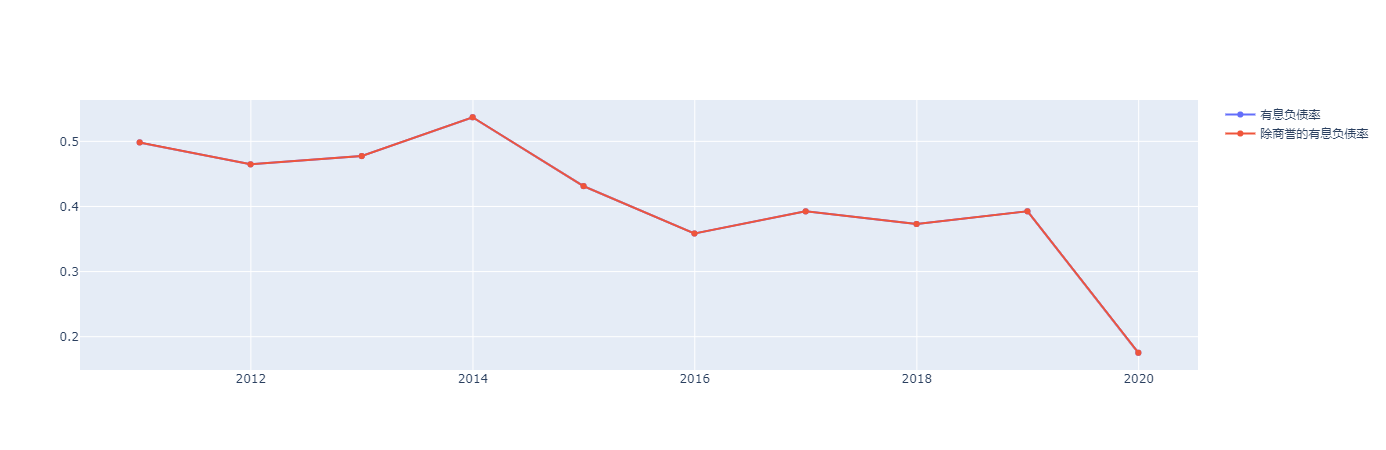

In [246]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data_df.index, y=data_df['debts_yx']/ data_df['total_assets'],name='有息负债率'))
fig.add_trace(go.Scatter(x=data_df.index, y=data_df['debts_yx'] / (data_df['total_assets'] - data_df['goodwill']),name='除商誉的有息负债率'))
fig.show()



## 现金及等价物/有息负债

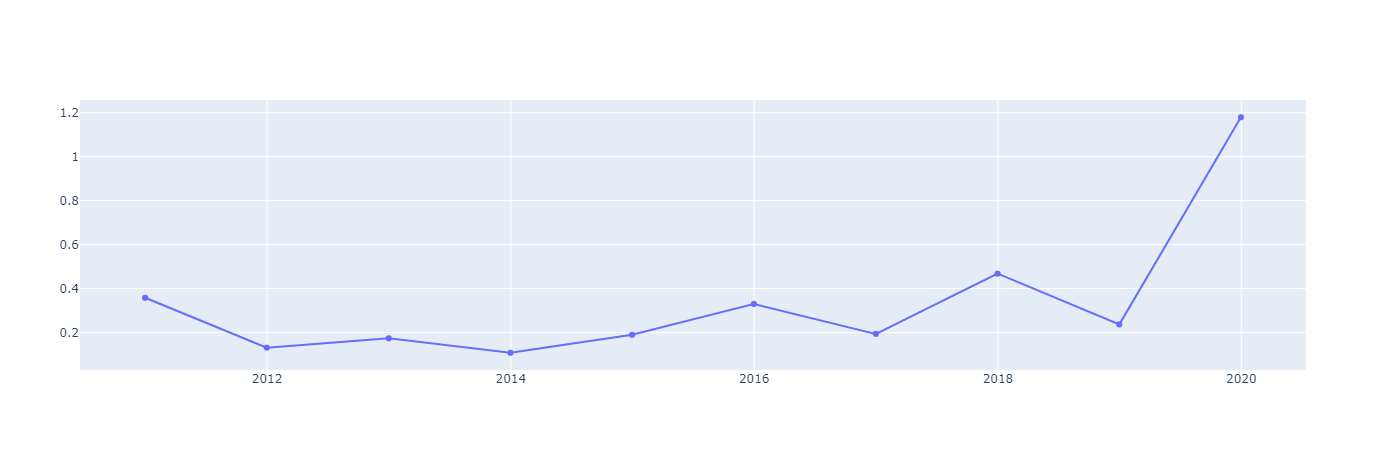

In [247]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data_df.index, y=data_df['money_cap']/data_df['debts_yx'],name='有息负债率'))
fig.show()


# 盈利能力

## 核心利润

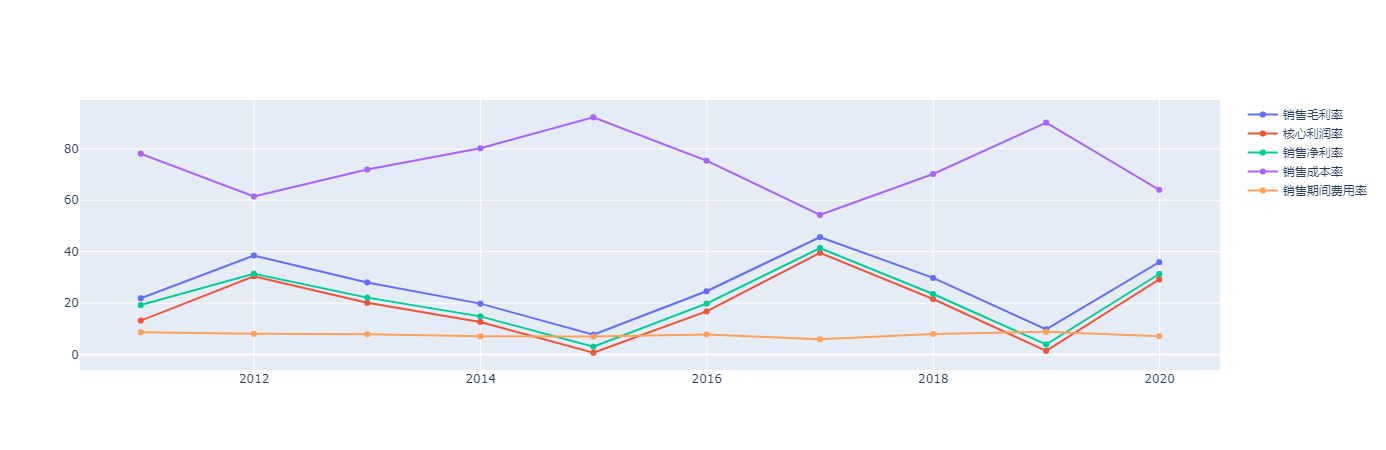

In [248]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=data_df.index, y=data_df.grossprofit_margin, name='销售毛利率'))
fig.add_trace(go.Scatter(x=data_df.index, y=data_df.oper_profit_ratio, name='核心利润率'))
fig.add_trace(go.Scatter(x=data_df.index, y=data_df.netprofit_margin, name='销售净利率'))
fig.add_trace(go.Scatter(x=data_df.index, y=data_df.cogs_of_sales, name='销售成本率'))
fig.add_trace(go.Scatter(x=data_df.index, y=data_df.expense_of_sales, name='销售期间费用率'))

fig.show()
# px.line(data_df,x='end_date',y=['total_revenue','operate_profit','n_income'])

## 费用占比

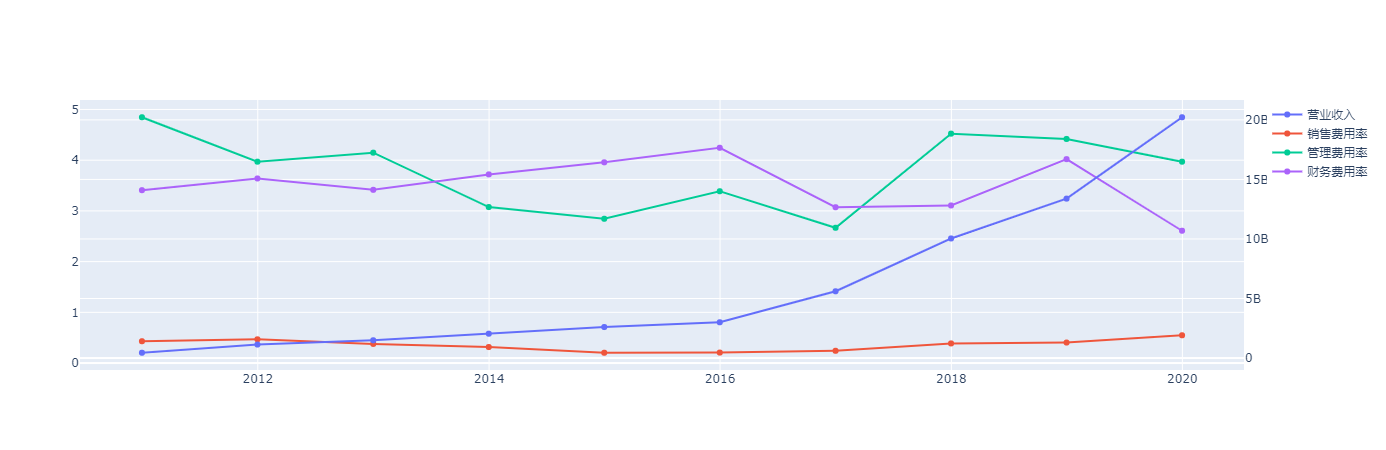

In [249]:
## 使用bar，对比分组数据
fig = go.Figure()
fig.add_trace(go.Scatter(x=data_df.index, y=data_df.revenue, name='营业收入',yaxis='y2'))
fig.add_trace(go.Scatter(x=data_df.index, y=data_df.saleexp_to_gr, name='销售费用率'))
fig.add_trace(go.Scatter(x=data_df.index, y=data_df.adminexp_of_gr, name='管理费用率'))
fig.add_trace(go.Scatter(x=data_df.index, y=data_df.finaexp_of_gr, name='财务费用率'))

fig.update_layout(yaxis2=dict(anchor='x', overlaying='y', side='right'))#设置坐标轴的格式，一般次坐标轴在右侧
fig.show()
# px.line(data_df,x='end_date',y=['total_revenue','operate_profit','n_income'])

# 成长性

## 营收、扣非、净利润增长

In [250]:
data_df['profit_dedt_yoy'] = data_df.profit_dedt/data_df.profit_dedt.shift(1)
data_df['revenue_yoy'] = data_df.revenue/data_df.revenue.shift(1)


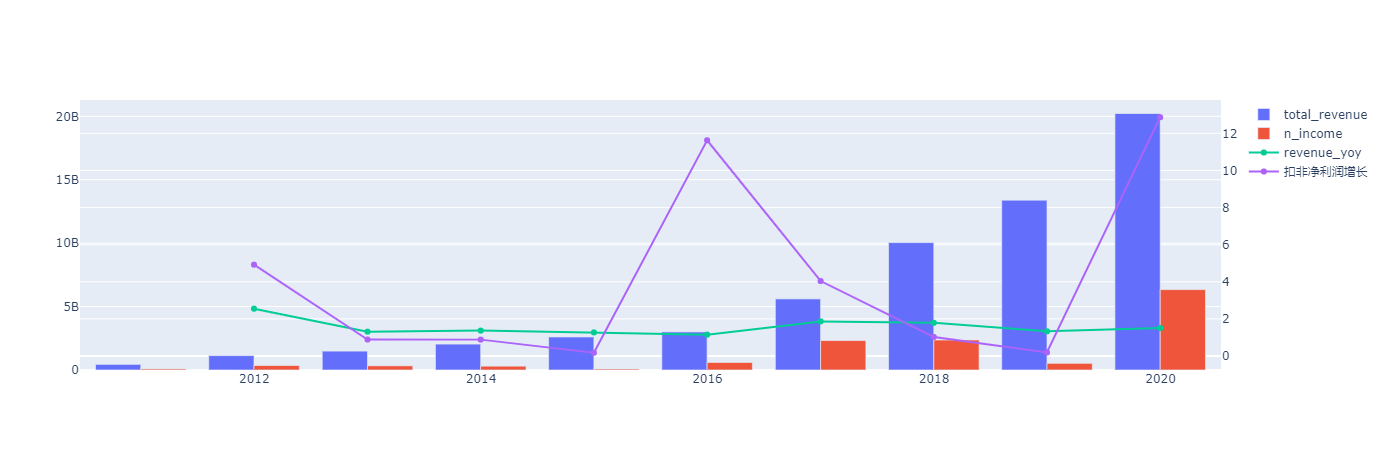

In [251]:
fig = go.Figure()

fig.add_trace(go.Bar(x=data_df.index, y=data_df.total_revenue, name='total_revenue',offsetgroup=0))
fig.add_trace(go.Bar(x=data_df.index, y=data_df.n_income,name='n_income', offsetgroup=1))

fig.add_trace(go.Scatter(x=data_df.index, y=data_df.revenue_yoy,name='revenue_yoy', yaxis='y2'))
fig.add_trace(go.Scatter(x=data_df.index, y=data_df.profit_dedt_yoy,name='扣非净利润增长', yaxis='y2'))

fig.update_layout(yaxis2=dict(anchor='x', overlaying='y', side='right'))#设置坐标轴的格式，一般次坐标轴在右侧
fig.show()

## 总资产、净资产增长率

In [252]:
data_df['total_ass_yoy'] = data_df.total_assets/data_df.total_assets.shift(1)
data_df['total_hldr_eqy_inc_min_int_yoy'] = data_df.total_hldr_eqy_inc_min_int/data_df.total_hldr_eqy_inc_min_int.shift(1)


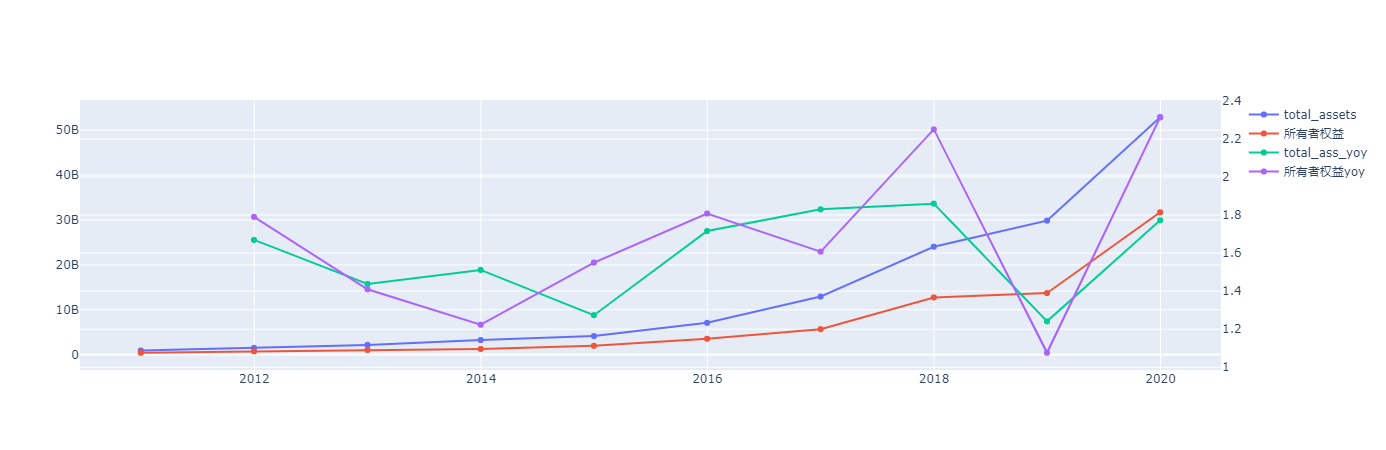

In [253]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data_df.index, y=data_df.total_assets,name='total_assets'))
fig.add_trace(go.Scatter(x=data_df.index, y=data_df.total_hldr_eqy_inc_min_int,name='所有者权益'))

fig.add_trace(go.Scatter(x=data_df.index, y=data_df.total_ass_yoy , yaxis='y2',name='total_ass_yoy'))
fig.add_trace(go.Scatter(x=data_df.index, y=data_df.total_hldr_eqy_inc_min_int_yoy , yaxis='y2',name='所有者权益yoy'))

fig.update_layout(yaxis2=dict(anchor='x', overlaying='y', side='right'))#设置坐标轴的格式，一般次坐标轴在右侧
fig.show()

# 利润质量

## 营业收入 vs 销售收现

1. total_revenue	营业总收入
2. c_fr_sale_sg	销售商品、提供劳务收到的现金
3. salescash_to_or	销售商品提供劳务收到的现金/营业收入

In [254]:
data_df['salescash_to_or'] = data_df.c_fr_sale_sg / data_df.total_revenue

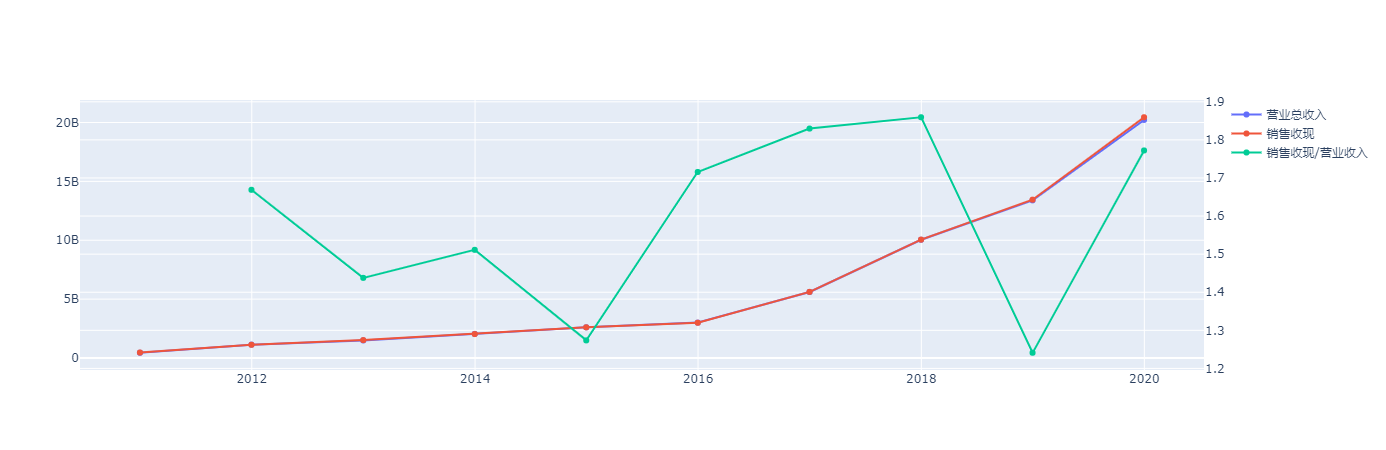

In [255]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data_df.index, y=data_df.total_revenue,name='营业总收入'))
fig.add_trace(go.Scatter(x=data_df.index, y=data_df.c_fr_sale_sg,name='销售收现'))

fig.add_trace(go.Scatter(x=data_df.index, y=data_df.total_ass_yoy ,name='销售收现/营业收入', yaxis='y2',))
fig.update_layout(yaxis2=dict(anchor='x', overlaying='y', side='right'))#设置坐标轴的格式，一般次坐标轴在右侧
fig.show()

## 净利润 vs 经营现金流净额

1. profit_dedt	扣除非经常性损益后的净利润
2. n_income	净利润(含少数股东损益)
3. n_cashflow_act	经营活动产生的现金流量净额


In [256]:
data_df['n_income_to_cha'] = data_df['n_cashflow_act']/data_df['n_income'] 
data_df['profit_dedt_to_cha'] = data_df['n_cashflow_act']/data_df['profit_dedt'] 

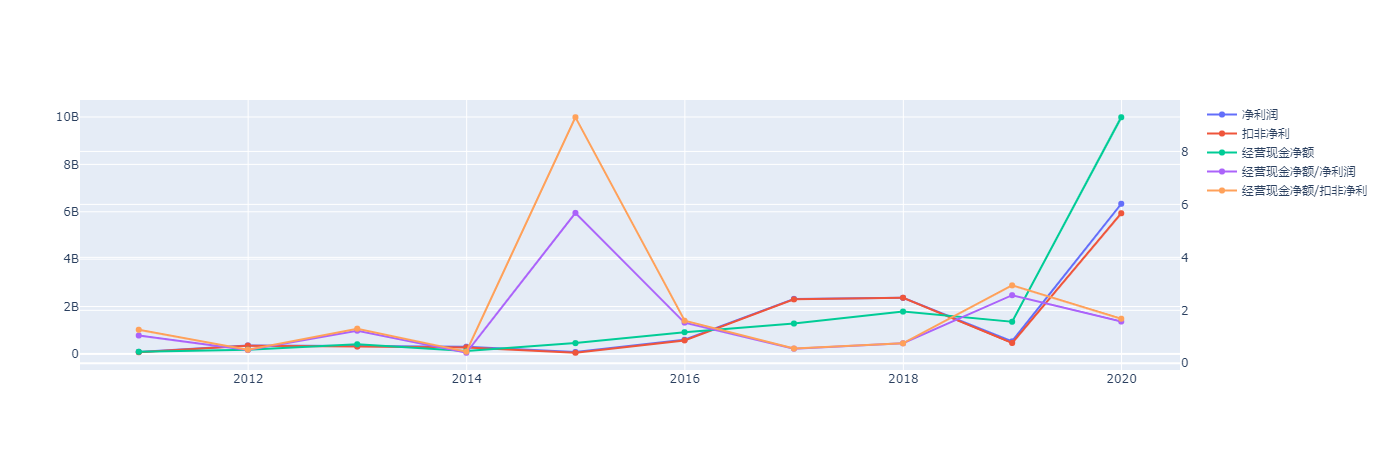

In [257]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data_df.index, y=data_df.n_income,name='净利润'))
fig.add_trace(go.Scatter(x=data_df.index, y=data_df.profit_dedt,name='扣非净利'))
fig.add_trace(go.Scatter(x=data_df.index, y=data_df.n_cashflow_act,name='经营现金净额'))

fig.add_trace(go.Scatter(x=data_df.index, y=data_df.n_income_to_cha ,name='经营现金净额/净利润', yaxis='y2',))
fig.add_trace(go.Scatter(x=data_df.index, y=data_df.profit_dedt_to_cha ,name='经营现金净额/扣非净利', yaxis='y2',))
fig.update_layout(yaxis2=dict(anchor='x', overlaying='y', side='right'))#设置坐标轴的格式，一般次坐标轴在右侧
fig.show()

# 管理层能力

## 应收账款周转率

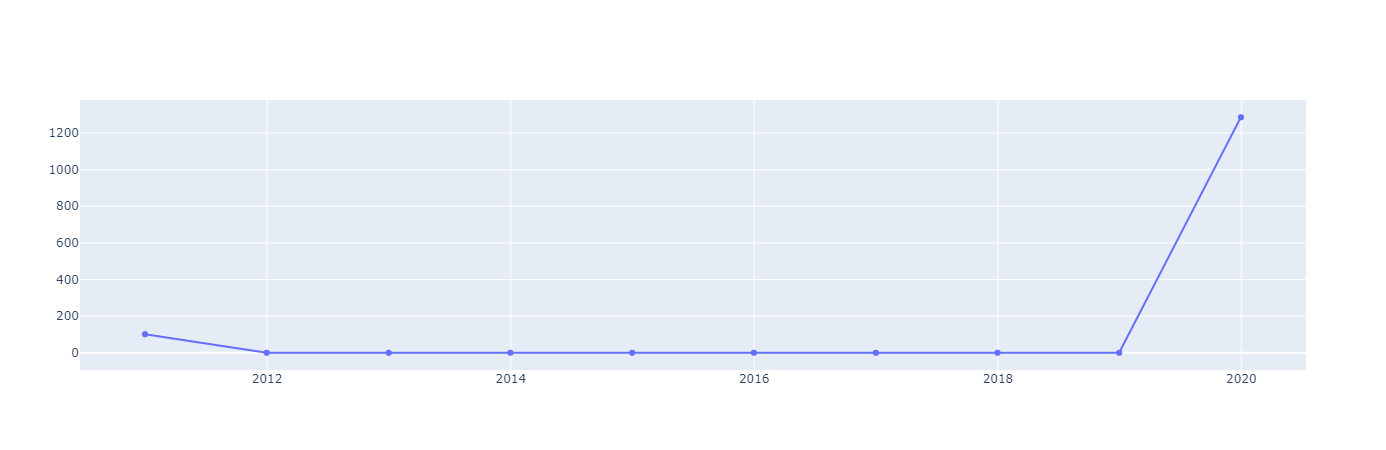

In [258]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data_df.index, y=data_df['ar_turn'],name='应收账款周转率'))
fig.show()


## 资产周转率

In [259]:
cols_turn = {"inv_turn":"存货周转率",
"ca_turn":"流动资产周转率",
"fa_turn":"固定资产周转率",
"assets_turn":"总资产周转率"}

In [260]:
data_df['inv_turn'] = data_df['revenue'] / data_df['inventories']

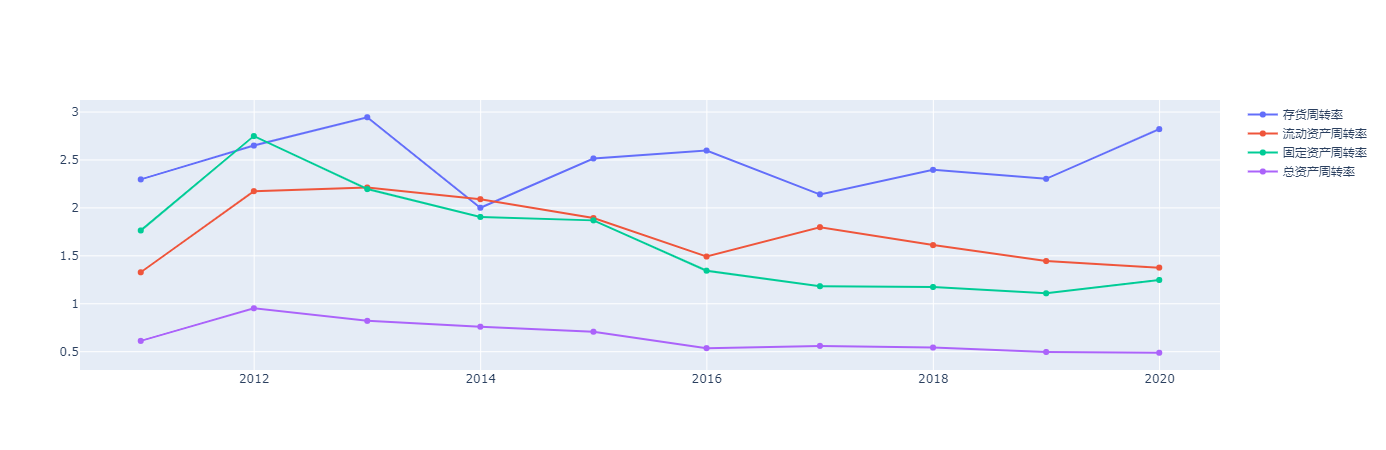

In [261]:
fig = go.Figure()
for col in cols_turn:
    fig.add_trace(go.Scatter(x=data_df.index, y=data_df[col],name=cols_turn[col]))
fig.show()


# 资产负债表

## 资产负债表中的几个比率

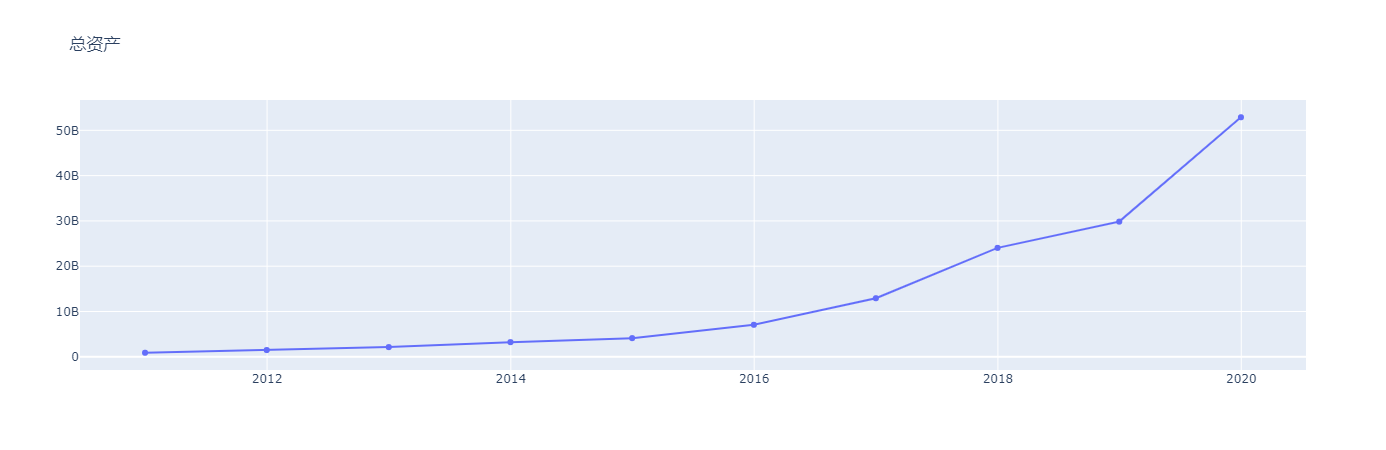

In [262]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data_df.index, y=data_df.total_assets))
fig.update_layout(title='总资产')
fig.show()

## 货币资金的比率

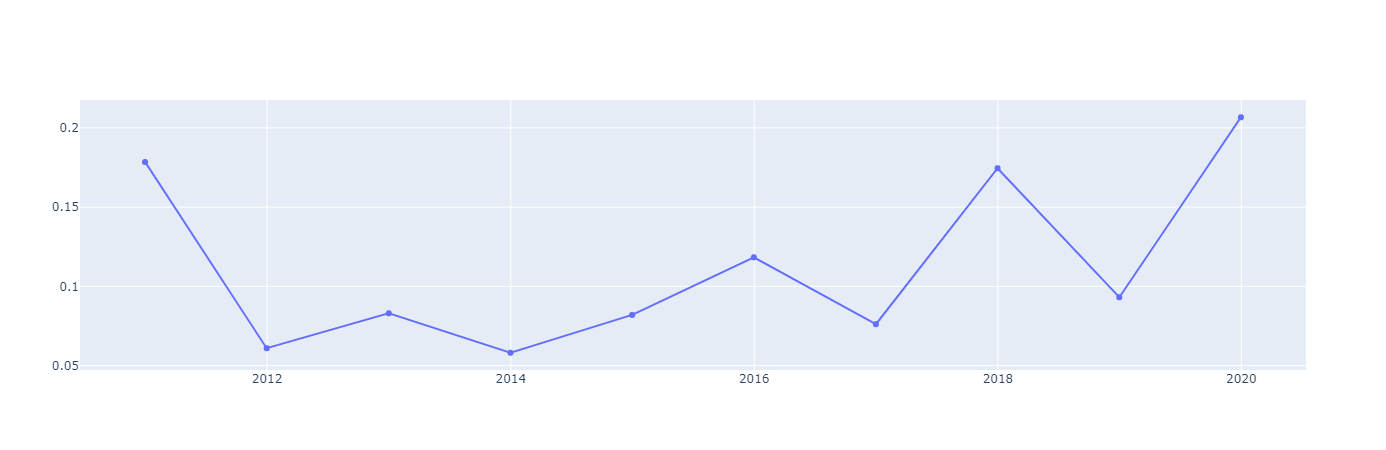

In [263]:
data_df['money_cap_ratio'] = data_df['money_cap']/data_df['total_assets']
fig = go.Figure()
fig.add_trace(go.Scatter(x=data_df.index, y=data_df.money_cap_ratio))
fig.show()

## 经营资产比率

In [264]:
cols_op = {"notes_receiv":"应收票据",
"accounts_receiv":"应收账款",
"oth_receiv":"其他应收款",
"prepayment":"预付款项",
"div_receiv":"应收股利",
"int_receiv":"应收利息",
"inventories":"存货",
"produc_bio_assets":"生产性生物资产"}

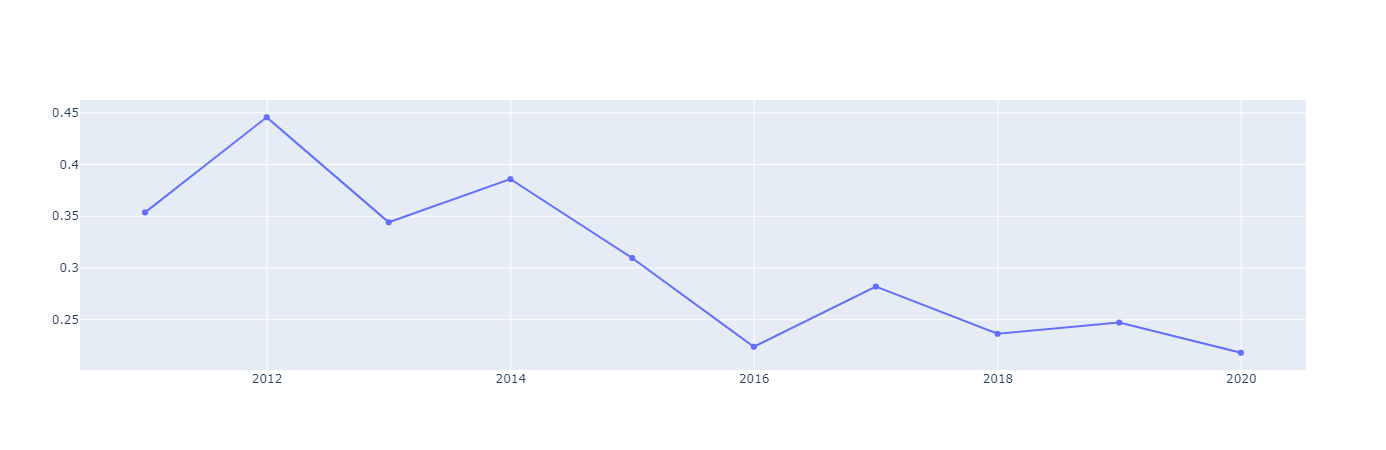

In [265]:
data_df['op_ratio'] = data_df[cols_op.keys()].sum(axis=1)/data_df['total_assets']
fig = go.Figure()
fig.add_trace(go.Scatter(x=data_df.index, y=data_df.op_ratio))
fig.show()

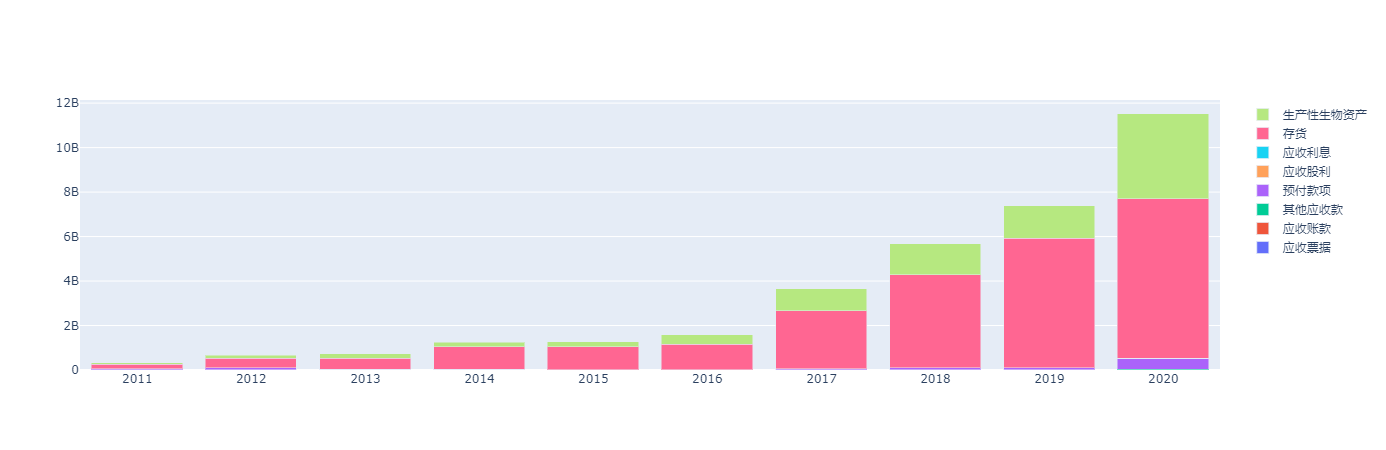

In [266]:
fig = go.Figure()
for col in cols_op:
    fig.add_trace(go.Bar(x=data_df.index, y=data_df[col], name=cols_op[col]))

# Change the bar mode
fig.update_layout(barmode='stack')
fig.show()

### 经营资产 vs 营收

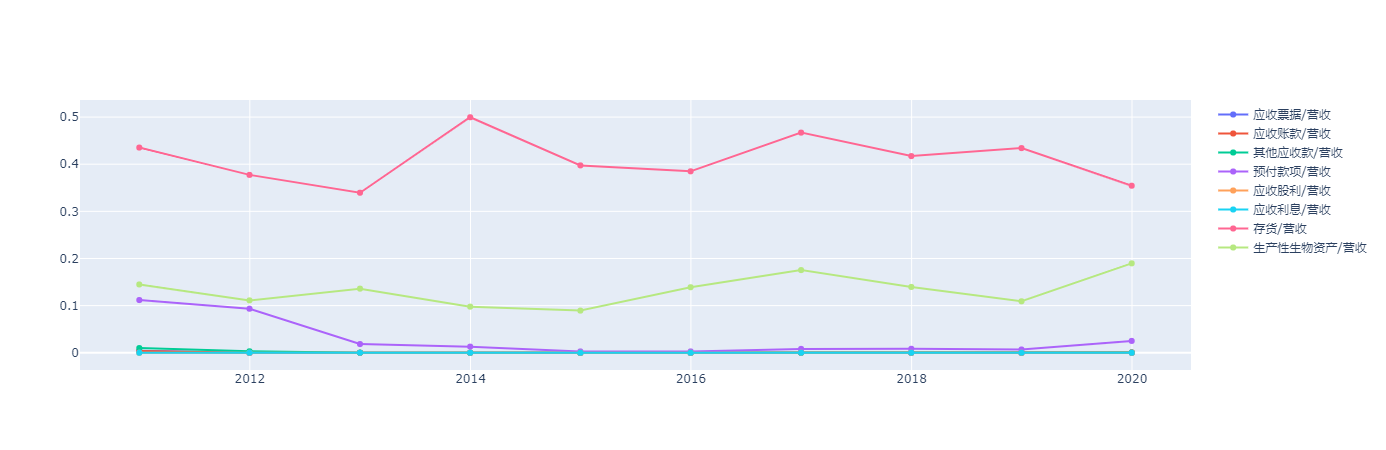

In [267]:
fig = go.Figure()
for col in cols_op:
    fig.add_trace(go.Scatter(x=data_df.index, y=data_df[col]/data_df.total_revenue, name=cols_op[col]+"/营收"))

# Change the bar mode
fig.update_layout(barmode='stack')
fig.show()

## 生产资产

In [268]:
cols_prod = {"fix_assets":"固定资产",
"cip":"在建工程",
"const_materials":"工程物资",
"intan_assets":"无形资产",
"goodwill":"商誉",
"lt_amor_exp":"长期待摊费用",
"defer_tax_assets":"递延所得税资产"}
# ？递延所得税资产 or 负债？

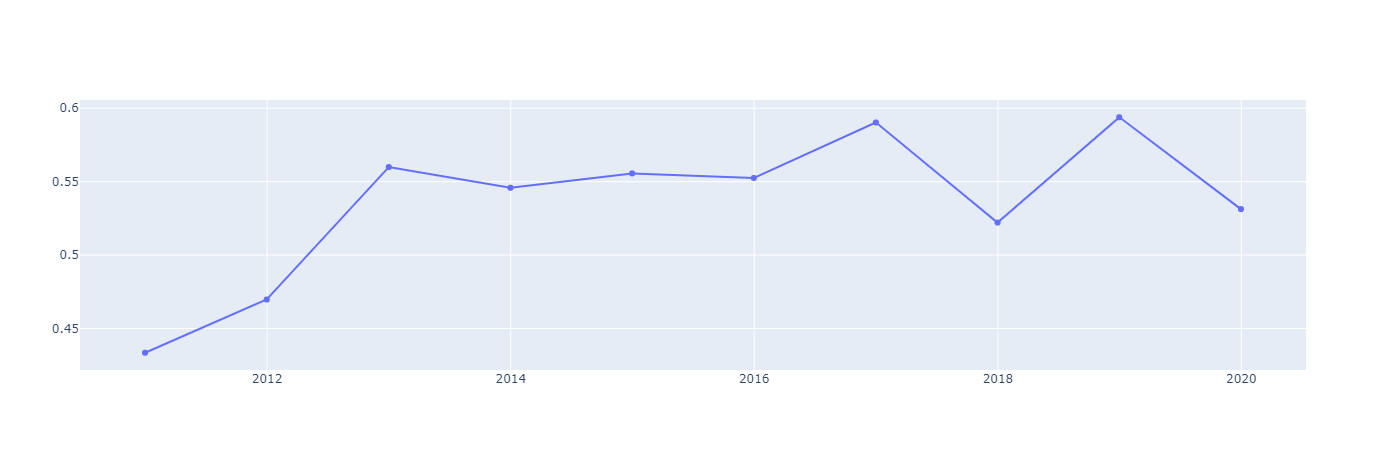

In [269]:
data_df['prod_ratio'] = data_df[cols_prod.keys()].sum(axis=1)/data_df['total_assets']
fig = go.Figure()
fig.add_trace(go.Scatter(x=data_df.index, y=data_df.prod_ratio))
fig.show()

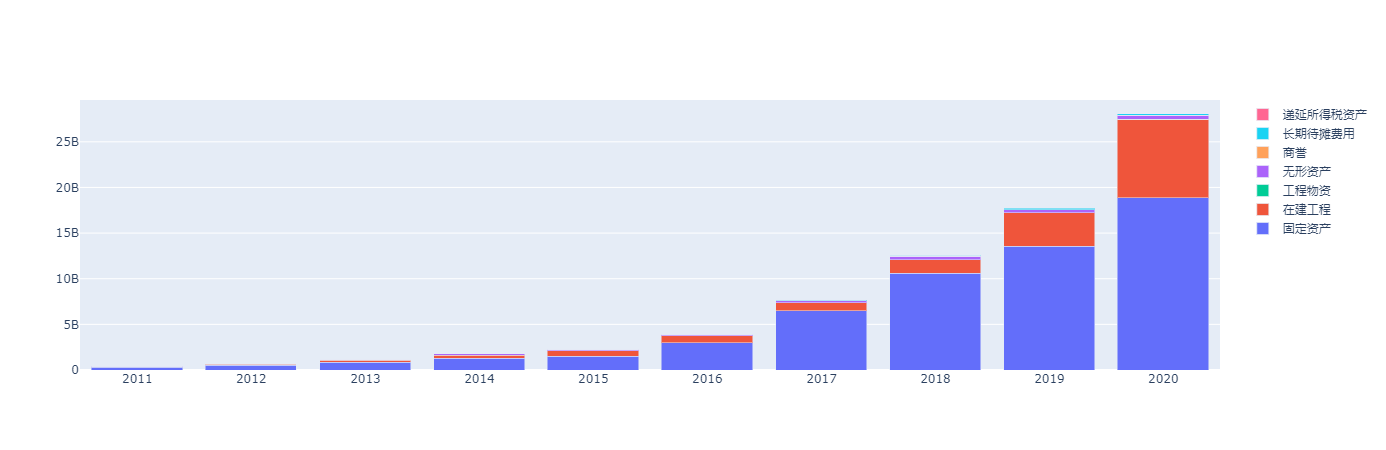

In [270]:
fig = go.Figure()
for col in cols_prod:
    fig.add_trace(go.Bar(x=data_df.index, y=data_df[col], name=cols_prod[col]))

# Change the bar mode
fig.update_layout(barmode='stack')
fig.show()

### 生产资产 vs 营收

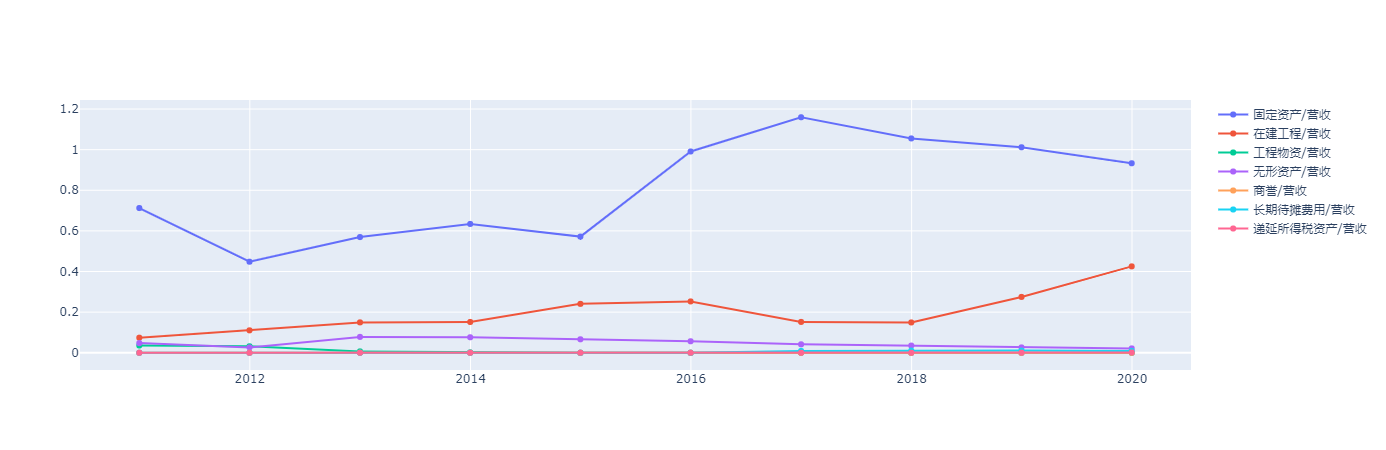

In [271]:
fig = go.Figure()
for col in cols_prod:
    fig.add_trace(go.Scatter(x=data_df.index, y=data_df[col]/data_df.total_revenue, name=cols_prod[col]+"/营收"))

# Change the bar mode
fig.update_layout(barmode='stack')
fig.show()

## 轻重比

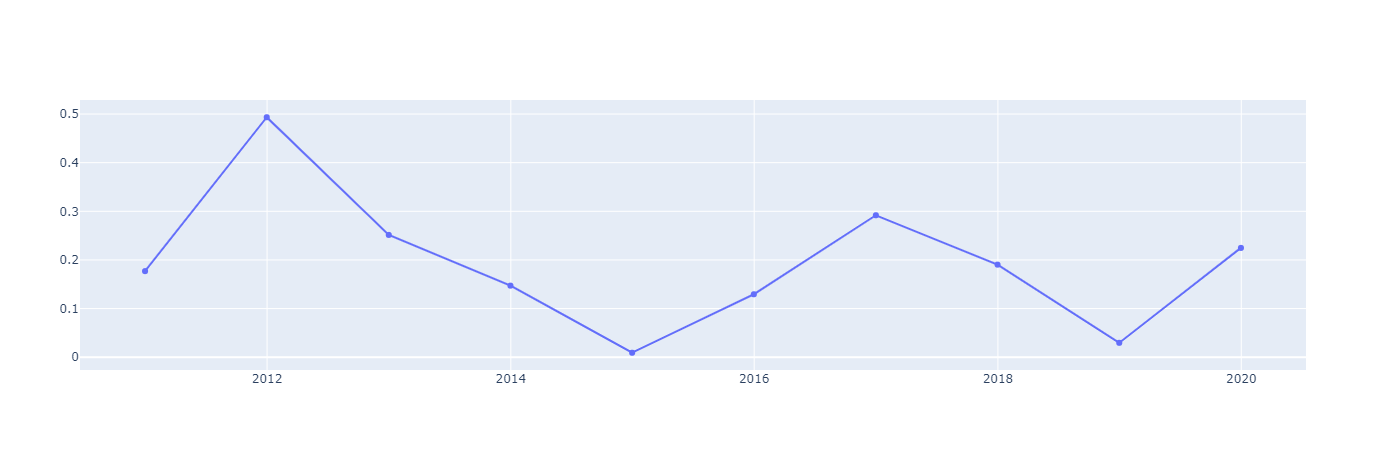

In [272]:
data_df['opp_to_prodass'] = data_df['operate_profit']/data_df[cols_prod.keys()].sum(axis=1)
fig = go.Figure()
fig.add_trace(go.Scatter(x=data_df.index, y=data_df.opp_to_prodass, name='轻重比')) ## 显著高于社会平均资本回报率则属于轻
fig.show()

## 非主营相关资产

In [273]:
cols_oth_ass = {
"trad_asset":"交易性金融资产",
"pur_resale_fa":"买入返售金融资产",
"oth_cur_assets":"其他流动资产",
"fa_avail_for_sale":"可供出售金融资产",
"htm_invest":"持有至到期投资",
"lt_eqt_invest":"长期股权投资",
"invest_real_estate":"投资性房地产"}

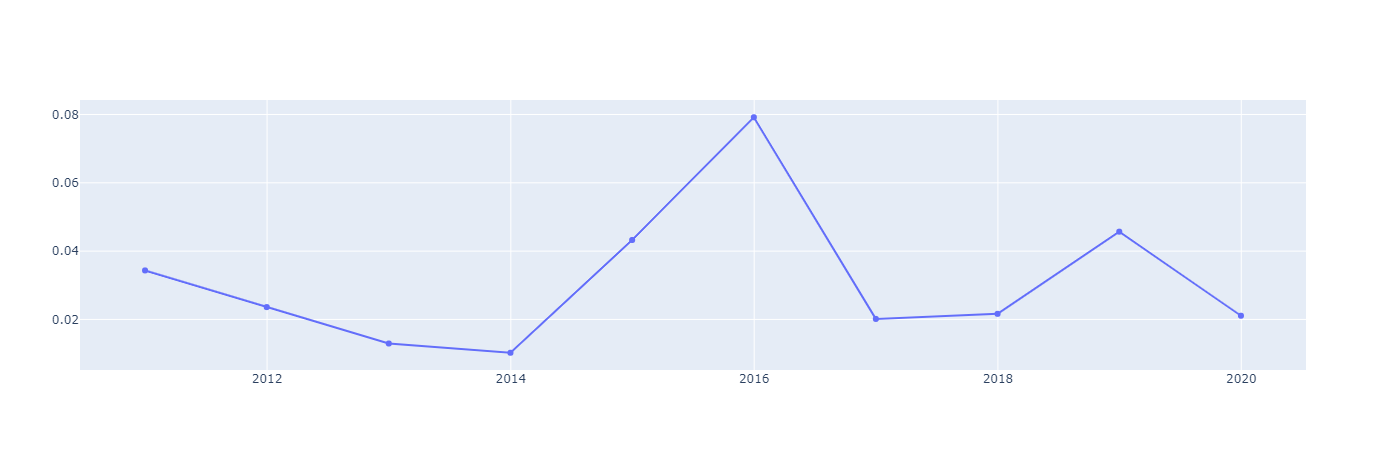

In [274]:
data_df['oth_ass_ratio'] = data_df[cols_oth_ass.keys()].sum(axis=1)/data_df['total_assets']
fig = go.Figure()
fig.add_trace(go.Scatter(x=data_df.index, y=data_df.oth_ass_ratio))
fig.show()

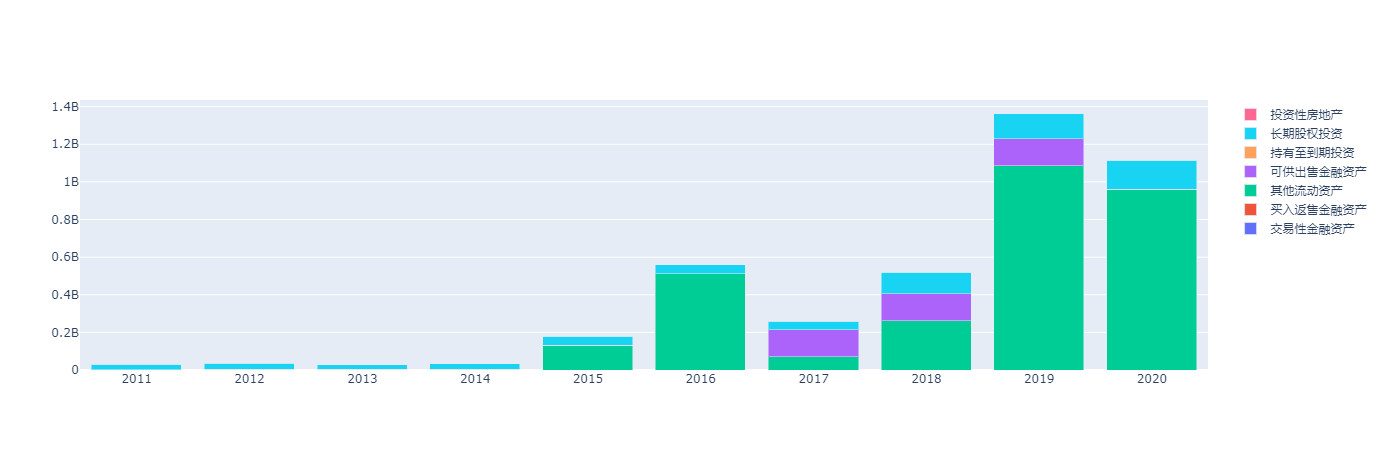

In [275]:
fig = go.Figure()
for col in cols_oth_ass:
    fig.add_trace(go.Bar(x=data_df.index, y=data_df[col], name=cols_oth_ass[col]))

# Change the bar mode
fig.update_layout(barmode='stack')
fig.show()

In [276]:
83/2265

0.03664459161147903

In [277]:
## 2019理财收益
35/2335
## ？？大股东占用资金？

0.014989293361884369

In [278]:
# 除商誉外的资产负债率
# 安全性

# 利润表

## 净利率与费用率

In [279]:
cols_incrs = {"netprofit_margin":"销售净利率",
"grossprofit_margin":"销售毛利率",
"cogs_of_sales":"销售成本率"}

In [280]:
data_df['exp_ratio'] = (data_df['sell_exp'] + data_df['admin_exp'] + data_df['fin_exp'].apply(lambda x:x if x>0 else 0)) / data_df['revenue']

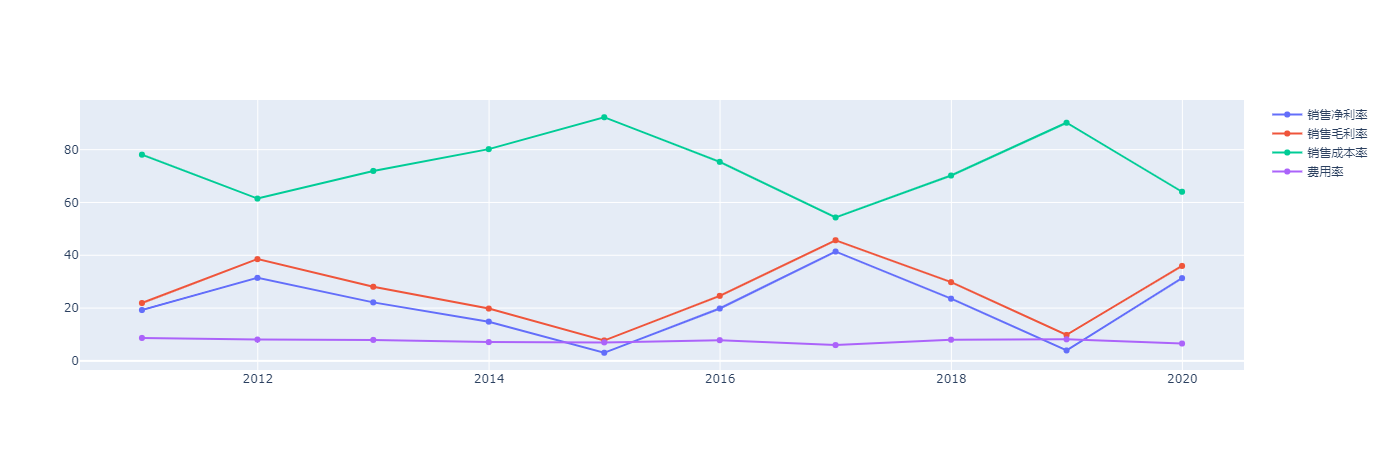

In [281]:
fig = go.Figure()
for col in cols_incrs:
    fig.add_trace(go.Scatter(x=data_df.index, y=data_df[col], name=cols_incrs[col]))
fig.add_trace(go.Scatter(x=data_df.index, y=data_df.exp_ratio*100, name='费用率'))
fig.show()
# px.line(data_df,x='end_date',y=['total_revenue','operate_profit','n_income'])

## 费用占比

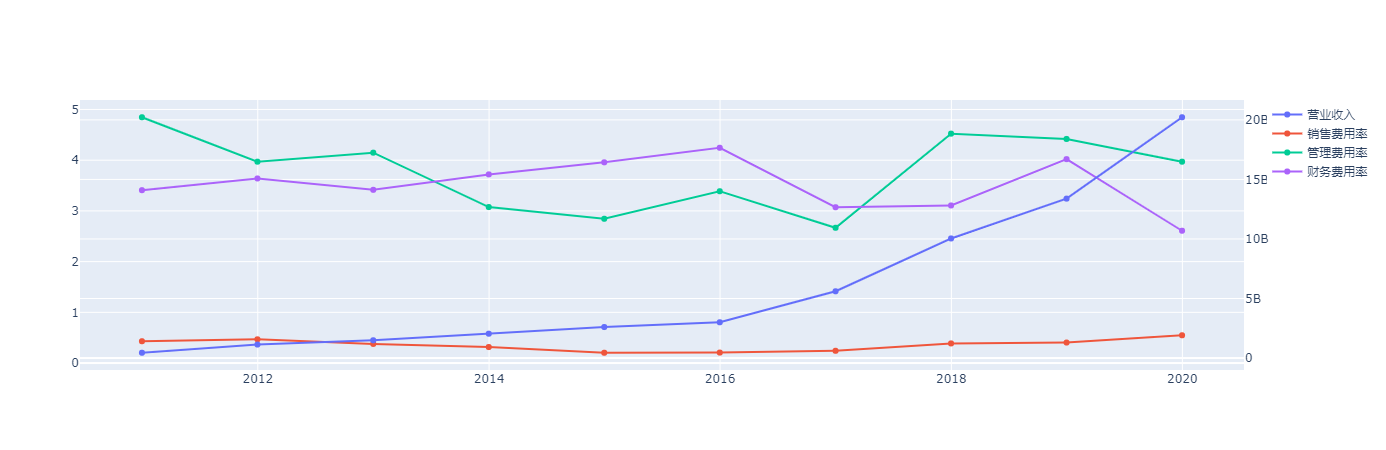

In [282]:
## 使用bar，对比分组数据
fig = go.Figure()
fig.add_trace(go.Scatter(x=data_df.index, y=data_df.revenue, name='营业收入',yaxis='y2'))
fig.add_trace(go.Scatter(x=data_df.index, y=data_df.saleexp_to_gr, name='销售费用率'))
fig.add_trace(go.Scatter(x=data_df.index, y=data_df.adminexp_of_gr, name='管理费用率'))
fig.add_trace(go.Scatter(x=data_df.index, y=data_df.finaexp_of_gr, name='财务费用率'))

fig.update_layout(yaxis2=dict(anchor='x', overlaying='y', side='right'))#设置坐标轴的格式，一般次坐标轴在右侧
fig.show()
# px.line(data_df,x='end_date',y=['total_revenue','operate_profit','n_income'])

# 现金流量表

## 三种现金流量覆盖情况

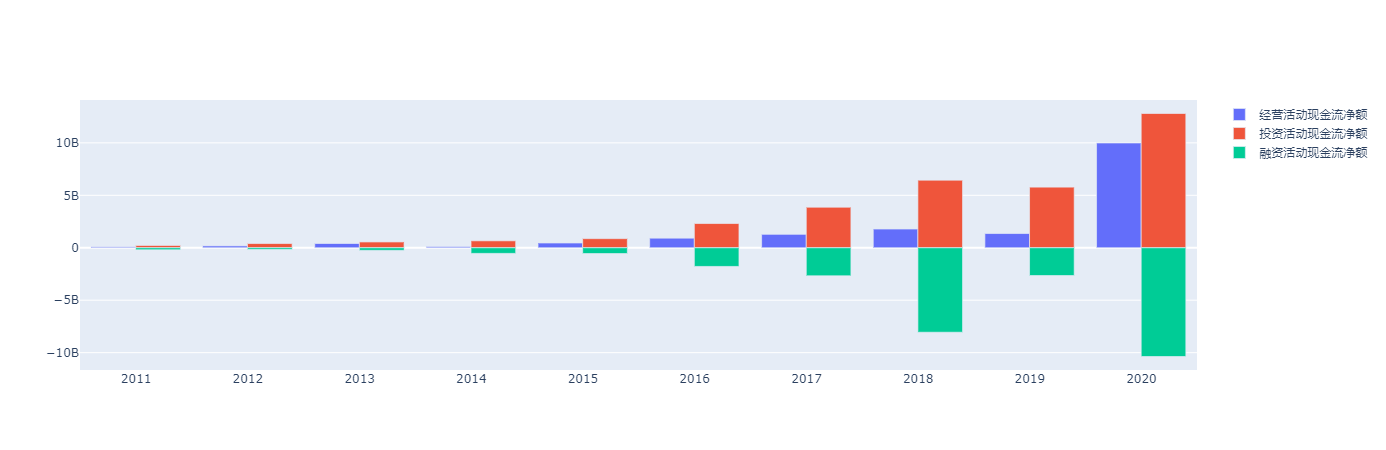

In [283]:
## 使用bar，对比分组数据
fig = go.Figure()
fig.add_trace(go.Bar(x=data_df.index, y=data_df.n_cashflow_act, offsetgroup=0, name='经营活动现金流净额'))
fig.add_trace(go.Bar(x=data_df.index, y=-data_df.n_cashflow_inv_act, offsetgroup=1, name='投资活动现金流净额'))
fig.add_trace(go.Bar(x=data_df.index, y=-data_df.n_cash_flows_fnc_act, offsetgroup=1,name='融资活动现金流净额'))
fig.show()
# px.line(data_df,x='end_date',y=['total_revenue','operate_profit','n_income'])

# 字典转化

In [284]:
text = """
notes_payable	应付票据
acct_payable	应付账款
oth_payable	其他应付款
st_borr	短期借款


"""
for line in text.split("\n"):
    if "\t" not in line:continue
    k,c = line.split("\t")
    print(f'"{k}":"{c}",')

"notes_payable":"应付票据",
"acct_payable":"应付账款",
"oth_payable":"其他应付款",
"st_borr":"短期借款",
